<a href="https://colab.research.google.com/github/msakthiganesh/cse-576-nlp/blob/main/NLP_attention_x10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Nov 29 20:47:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%cd /content/drive/MyDrive/NLP/

/content/drive/MyDrive/NLP


In [4]:
# !unzip transformers-main.zip

In [3]:
%cd transformers-main

/content/drive/MyDrive/NLP/transformers-main


In [4]:
# !pip uninstall transformers -y
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/NLP/transformers-main
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.6 MB 31.5 MB/s 
     |████████████████████████████████| 182 kB 62.6 MB/s 
  Running setup.py develop for transformers


In [5]:
%cd src/

/content/drive/MyDrive/NLP/transformers-main/src


In [6]:
import os
import json
import glob
import pandas as pd
from tqdm.notebook import tqdm

### Data Preprocessing

In [19]:
# GPT3_DATA_DIR = "/content/drive/MyDrive/NLP/data/gpt3_data/"

# json_pattern = os.path.join(GPT3_DATA_DIR, '*.json')
# file_list = glob.glob(json_pattern)

In [ ]:
# logic_type, logic_subtype, logic_type_code, Premise, Hypothesis, Label = [], [], [], [], [], []

# for single_file in file_list:
#   with open(single_file, 'r') as f:
#     try:
#       json_file = json.load(f)
#       for i in range(len(json_file)):
#         if (json_file[i]["logic_type"] and json_file[i]["logic_subtype"] and json_file[i]["logic_type_code"] 
#             and json_file[i]["Premise"] and json_file[i]["Hypothesis"] and json_file[i]["Label"]):
#           logic_type.append(json_file[i]["logic_type"])
#           logic_subtype.append(json_file[i]["logic_subtype"])
#           logic_type_code.append(json_file[i]["logic_type_code"])
#           Premise.append(json_file[i]["Premise"])
#           Hypothesis.append(json_file[i]["Hypothesis"])
#           Label.append(json_file[i]["Label"][0])
#         else:
#           print(f'Error in Parsing {single_file}')
#     except Exception as e:
#       print(f'Skipping {single_file} == {e}')

In [ ]:
with open("data/train.json", "r") as f_train:
  gpt3_json = json.load(f_train)

gpt3_data = pd.json_normalize(gpt3_json, sep=',').reset_index()

In [ ]:
with open("data/test.json", "r") as f_test:
  test_json = json.load(f_test)

test_data = pd.json_normalize(test_json).reset_index()

In [ ]:
_gpt3_data_labels, _uneven_gpt3 = [], []
for i in range(gpt3_data.shape[0]):
  if len(gpt3_data.Label[i]) > 1:
    _gpt3_data_labels.append(i)
  
  if len(gpt3_data.Label[i]) != len(gpt3_data.Hypothesis[i]):
    _uneven_gpt3.append(i)

_test_data_labels, _uneven_test = [], []
for i in range(test_data.shape[0]):
  if len(test_data.Label[i]) > 1:
    _test_data_labels.append(i)

  if len(test_data.Label[i]) != len(test_data.Hypothesis[i]):
    _uneven_test.append(i)

In [ ]:
len(_gpt3_data_labels), len(_test_data_labels), len(_uneven_gpt3), len(_uneven_test)

(133, 89, 1, 14)

In [ ]:
gpt3_data.shape, test_data.shape

((2187, 8), (1317, 7))

In [ ]:
for idx in _uneven_gpt3:
  gpt3_data.drop(index=idx, inplace=True)

for idx in _uneven_test:
  test_data.drop(index=idx, inplace=True)

for idx in _gpt3_data_labels:
  if idx not in _uneven_gpt3:
    gpt3_data.drop(index=idx, inplace=True)

for idx in _test_data_labels:
  if idx not in _uneven_test:
    test_data.drop(index=idx, inplace=True)

gpt3_data.shape, test_data.shape

((2053, 8), (1215, 7))

In [ ]:
gpt3_data.columns

Index(['index', 'logic_type', 'logic_subtype', 'logic_type_code', 'Premise',
       'Hypothesis', 'Label', 'id'],
      dtype='object')

In [ ]:
gpt3_data.drop(columns=["id"], inplace=True)

In [ ]:
test_data.columns

Index(['index', 'logic_type', 'logic_subtype', 'logic_type_code', 'Premise',
       'Hypothesis', 'Label'],
      dtype='object')

In [ ]:
# len(logic_type), len(logic_subtype), len(logic_type_code), len(Premise), len(Hypothesis), len(Label)

In [ ]:
# df = pd.DataFrame(data = zip(logic_type, logic_subtype, logic_type_code, Premise, Hypothesis, Label), 
#                   columns = ['logic_type', 'logic_subtype', 'logic_type_code', 'Premise', 'Hypothesis', 'Label'])

In [ ]:
gpt3_data.iloc[2039]["Premise"]

['If I am at school, I will learn.', 'I am at school.']

In [ ]:
def list_to_str(list_vals):
  return ". ".join(list_vals)

In [ ]:
gpt3_data["Premise"] = gpt3_data["Premise"].map(list_to_str)
test_data["Premise"] = test_data["Premise"].map(list_to_str)

In [ ]:
gpt3_data["Hypothesis"] = gpt3_data["Hypothesis"].map(list_to_str)
test_data["Hypothesis"] = test_data["Hypothesis"].map(list_to_str)

In [ ]:
gpt3_data["Label"] = gpt3_data["Label"].map(list_to_str)
test_data["Label"] = test_data["Label"].map(list_to_str)

In [ ]:
gpt3_data.head(2)

,index,logic_type,logic_subtype,logic_type_code,Premise,Hypothesis,Label
0,0,First Order Logic,Universal Instantiation,F2,All elephants are mammals.. Curtis is an eleph...,Curtis is a mammal.,True
1,1,First Order Logic,Universal Instantiation,F2,All cats are animals.. Luna is a cat.,Luna is an animal.,True


In [ ]:
test_data.head(2)

,index,logic_type,logic_subtype,logic_type_code,Premise,Hypothesis,Label
0,0,Reasoning about Action,Frame Problem for Temporal Projection,D1,"After an action is performed, things normally ...","After the robot grasps the pipe, waits, then m...",True
1,1,Reasoning about Action,Frame Problem for Temporal Projection,D1,"After an action is performed, things normally ...","After the robot grasps the pipe, waits, then d...",False


In [ ]:
for index, row in gpt3_data.iterrows():
  row["Premise"] = row["Premise"].replace(".. ", ". ")
  row["Hypothesis"] = row["Hypothesis"].replace(".. ", ". ")

for index, row in test_data.iterrows():
  row["Premise"] = row["Premise"].replace(".. ", ". ")
  row["Hypothesis"] = row["Hypothesis"].replace(".. ", ". ")

In [ ]:
gpt3_data.to_csv("gpt3_data.csv", index=None)
test_data.to_csv("test_data.csv", index=None)

## EDA

In [7]:
df = pd.read_csv("/content/drive/MyDrive/NLP/gpt3_data.csv", index_col=None)

In [8]:
test_df = pd.read_csv("/content/drive/MyDrive/NLP/test_data.csv", index_col = None)

In [9]:
df.Label.value_counts()

True            1343
False            559
Undetermined     140
Flase              4
Ambiguous          4
ru                 1
als                1
 False             1
Name: Label, dtype: int64

In [10]:
test_df.Label.value_counts()

True             895
False            249
Undetermined      61
Undeterminded      6
Unknown            4
Name: Label, dtype: int64

In [11]:
df.drop(df.index[df['Label'] == "Flase"], inplace = True)
df.drop(df.index[df['Label'] == "Unknown"], inplace = True)
df.drop(df.index[df['Label'] == "ru"], inplace = True)
df.drop(df.index[df['Label'] == "Ambiguous"], inplace = True)
df.drop(df.index[df['Label'] == "als"], inplace = True)
df.drop(df.index[df['Label'] == " False"], inplace = True)



test_df.drop(test_df.index[test_df['Label'] == "Undeterminded"], inplace = True)
test_df.drop(test_df.index[test_df['Label'] == "Unknown"], inplace = True)

In [12]:
df.Label.value_counts()

True            1343
False            559
Undetermined     140
Name: Label, dtype: int64

In [13]:
test_df.Label.value_counts()

True            895
False           249
Undetermined     61
Name: Label, dtype: int64

In [14]:
label_to_map={
    "True":1,
    "False":0,
    "Undetermined":2
}

In [15]:
df["Labels"] = df["Label"].map(label_to_map)
test_df["Labels"] = test_df["Label"].map(label_to_map)

In [16]:
df.drop(columns=["Label"],inplace=True)
df.head(2)

,index,logic_type,logic_subtype,logic_type_code,Premise,Hypothesis,Labels
0,0,First Order Logic,Universal Instantiation,F2,All elephants are mammals.. Curtis is an eleph...,Curtis is a mammal.,1
1,1,First Order Logic,Universal Instantiation,F2,All cats are animals.. Luna is a cat.,Luna is an animal.,1


In [17]:
df.logic_subtype.value_counts()

Universal Instantiation                                  344
Generalized Modus Ponens                                 150
Frame Problem for Temporal Projection                    138
Universal Generalization                                 132
Basic Default Reasoning                                  128
Temporal Projection                                      119
Disjunctive Syllogism                                    101
Modus Tollens                                            101
Modus Ponens                                              97
Hypothetical Syllogism                                    88
Generalized Modus Ponens Rule                             56
Reasoning about unknown exceptions II                     52
Constructive Dilemma                                      51
Hypothetical syllogism                                    50
Default Reasoning in an Open Domain                       50
Default Reasoning with a Disabled Default                 50
Disjunctive syllogism   

## Modeling


### Baseline - RoBERTa 

In [18]:
# !pip install transformers

In [19]:
import time, datetime

In [20]:
from transformers import RobertaModel, RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig, get_linear_schedule_with_warmup, AdamW

In [21]:
# !pip list | grep trans

In [22]:
_config = RobertaConfig.from_pretrained("roberta-base") 

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [23]:
_config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [24]:
config = RobertaConfig.from_pretrained("roberta-base", num_labels=3) # hidden_size=768 must be a multiple of num_attention_heads
model = RobertaForSequenceClassification.from_pretrained("roberta-base", 
                                                         config=config
                                                         )

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [25]:
# config = RobertaConfig.from_pretrained("roberta-base", hidden_size = 1024, num_hidden_layers= 24, num_attention_heads=16, num_labels=3) # hidden_size=768 must be a multiple of num_attention_heads
# model = RobertaForSequenceClassification.from_pretrained("roberta-base", 
#                                                          config=config, 
#                                                          ignore_mismatched_sizes=True
#                                                          )

In [26]:
model.config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [27]:
# model

In [28]:
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [29]:
# roberta_config = RobertaConfig.from_pretrained("roberta-base")

In [30]:
import torch
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    df.drop(columns=["logic_type", "logic_subtype", "logic_type_code", "Labels"]),
    df["Labels"],
    stratify = df["Labels"],
    test_size = 0.2
)

In [32]:
y_train.value_counts()

1    1074
0     447
2     112
Name: Labels, dtype: int64

In [33]:
y_val.value_counts()

1    269
0    112
2     28
Name: Labels, dtype: int64

In [34]:
y_train.value_counts()[0]/y_val.value_counts()[0], y_train.value_counts()[1]/y_val.value_counts()[1], y_train.value_counts()[2]/y_val.value_counts()[2]

(3.9910714285714284, 3.992565055762082, 4.0)

In [35]:
X_train.head(2)

,index,Premise,Hypothesis
875,958,All of the candy will be gone soon.. At least ...,Exactly one piece of candy will not still be a...
45,45,All cars are vehicles.. The Ford Mustang is a ...,The Ford Mustang is not a vehicle.


In [36]:
test_df.head(2)

,index,logic_type,logic_subtype,logic_type_code,Premise,Hypothesis,Label,Labels
0,0,Reasoning about Action,Frame Problem for Temporal Projection,D1,"After an action is performed, things normally ...","After the robot grasps the pipe, waits, then m...",True,1
1,1,Reasoning about Action,Frame Problem for Temporal Projection,D1,"After an action is performed, things normally ...","After the robot grasps the pipe, waits, then d...",False,0


In [37]:
train_premise = X_train["Premise"].values
train_hypothesis = X_train["Hypothesis"].values
train_labels = y_train.values


val_premise = X_val["Premise"].values
val_hypothesis = X_val["Hypothesis"].values
val_labels = y_val.values

test_premise = test_df["Premise"].values
test_hypothesis = test_df["Hypothesis"].values
test_labels = test_df.Labels.values

In [38]:
max_len=0
for i in tqdm(range(0,len(train_premise))):
  input_ids = roberta_tok.encode(train_premise[i], train_hypothesis[i], add_special_tokens=True)
  max_len = max(max_len, len(input_ids))

print(f"Max Length in Train Dataset: {max_len}")

  0%|          | 0/1633 [00:00<?, ?it/s]

Max Length in Train Dataset: 156


In [39]:
def encode_input(premise, hypothesis, label, maxlen):

  encoded_input_ids = []
  encoded_input_attn_mask = []

  for i in tqdm(range(0, len(premise))):
    encoded_input = roberta_tok.encode_plus(premise[i],
                                        hypothesis[i],
                                        add_special_tokens=True,
                                        max_length=maxlen,
                                        return_attention_mask=True,
                                        return_tensors="pt",
                                        truncation=True,
                                        padding="max_length")
    
    encoded_input_ids.append(encoded_input.input_ids)
    encoded_input_attn_mask.append(encoded_input.attention_mask)

  encoded_input_ids = torch.cat(encoded_input_ids, dim=0)
  encoded_input_attn_mask = torch.cat(encoded_input_attn_mask, dim=0)
  label = torch.tensor(label, dtype=torch.long)

  return (encoded_input_ids, encoded_input_attn_mask, label)

In [40]:
train_encoded_input_ids, train_encoded_input_attn_mask, train_label = encode_input(premise = train_premise, hypothesis = train_hypothesis, label = train_labels, maxlen = 256)
val_encoded_input_ids, val_encoded_input_attn_mask, val_label = encode_input(premise = val_premise, hypothesis = val_hypothesis, label = val_labels, maxlen = 256)
test_encoded_input_ids, test_encoded_input_attn_mask, test_label = encode_input(premise = test_premise, hypothesis = test_hypothesis, label = test_labels, maxlen = 256)

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/409 [00:00<?, ?it/s]

  0%|          | 0/1205 [00:00<?, ?it/s]

In [41]:
print(f"Original Premise 1: {train_premise[0]}")
print(f"Original Hypothesis 2: {train_hypothesis[0]}")
print(f"Token IDs: {train_encoded_input_ids[0]}")
print(f"Attention Mask: {train_encoded_input_attn_mask[0]}")
print(f"Label: {train_labels[0]}")

Original Premise 1: All of the candy will be gone soon.. At least one piece of candy will still be available.
Original Hypothesis 2: Exactly one piece of candy will not still be available.
Token IDs: tensor([    0,  3684,     9,     5, 12644,    40,    28,  1613,  1010,  7586,
          497,   513,    65,  2125,     9, 12644,    40,   202,    28,   577,
            4,     2,     2, 46149,    65,  2125,     9, 12644,    40,    45,
          202,    28,   577,     4,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1

In [42]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [43]:
train_ds = TensorDataset(train_encoded_input_ids, train_encoded_input_attn_mask, train_label)
eval_ds = TensorDataset(val_encoded_input_ids, val_encoded_input_attn_mask, val_label)
test_ds= TensorDataset(test_encoded_input_ids, test_encoded_input_attn_mask, test_label)

In [44]:
config = {
    "eos_token" : "[SEP]",
    "batch_size" : 32,
    "random_seed" : 7
}

In [45]:
train_dataloader = DataLoader(
            train_ds,  
            sampler = RandomSampler(train_ds), 
            batch_size = config["batch_size"]
        )

validation_dataloader = DataLoader(
            eval_ds, 
            sampler = RandomSampler(eval_ds), 
            batch_size = config["batch_size"]
        )

test_dataloader = DataLoader(
            test_ds, 
            sampler = RandomSampler(test_ds), 
            batch_size = config["batch_size"]
        )

In [46]:
# roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base",
#                                                                  num_labels = 3,
#                                                                  output_attentions = False,
#                                                                  output_hidden_states = False
#                                                                  )

In [47]:
# roberta_model.config

In [48]:
# roberta_model.to("cuda:0")

In [49]:
model.to("cuda:0")

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [50]:
EPOCHS = 7
LR = 2e-5
EPS = 1e-8

optimizer = AdamW(model.parameters(), lr = LR, eps = EPS)
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = 0, 
                                           num_training_steps = total_steps)

/content/drive/MyDrive/NLP/transformers-main/src/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [51]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [52]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [53]:
import random
import numpy as np

In [54]:
random.seed(config["random_seed"])
np.random.seed(config["random_seed"])
torch.manual_seed(config["random_seed"])
torch.cuda.manual_seed_all(config["random_seed"])

In [55]:
for i in train_dataloader:
  print(f"{i[0]} \n\n {i[1]} \n\n {i[2]}")
  break

tensor([[   0, 3684, 6523,  ...,    1,    1,    1],
        [   0, 1106,   38,  ...,    1,    1,    1],
        [   0, 1106,   38,  ...,    1,    1,    1],
        ...,
        [   0,  100,   40,  ...,    1,    1,    1],
        [   0, 1106,    5,  ...,    1,    1,    1],
        [   0,  133,  674,  ...,    1,    1,    1]]) 

 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]) 

 tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        0, 1, 0, 0, 2, 0, 1, 1])


In [56]:
# CELL EXTRACTED FROM SAMPLE NOTEBOOK PROVIDED

training_stats = []
epochs = EPOCHS

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to("cuda:0")
        b_input_mask = batch[1].to("cuda:0")
        b_labels = batch[2].to("cuda:0")

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to("cuda:0")
        b_input_mask = batch[1].to("cuda:0")
        b_labels = batch[2].to("cuda:0")
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 7 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:52.

  Average training loss: 0.90
  Training epcoh took: 0:01:06

Running Validation...
  Accuracy: 0.66
  Validation Loss: 0.81
  Validation took: 0:00:06

======== Epoch 2 / 7 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:55.

  Average training loss: 0.83
  Training epcoh took: 0:01:09

Running Validation...
  Accuracy: 0.66
  Validation Loss: 0.81
  Validation took: 0:00:06

======== Epoch 3 / 7 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:54.

  Average training loss: 0.82
  Training epcoh took: 0:01:09

Running Validation...
  Accuracy: 0.65
  Validation Loss: 0.82
  Validation took: 0:00:06

======== Epoch 4 / 7 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:54.

  Average training loss: 0.81
  Training epcoh took: 0:01:09

Running Validation...
  Accuracy: 0.66
  Validation Loss: 0.83
  Validation took: 0:00:06

======== Epoch 5 / 7 ======

In [57]:
# CELL EXTRACTED FROM SAMPLE NOTEBOOK PROVIDED

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.90,0.81,0.66,0:01:06,0:00:06
2,0.83,0.81,0.66,0:01:09,0:00:06
3,0.82,0.82,0.65,0:01:09,0:00:06
4,0.81,0.83,0.66,0:01:09,0:00:06
5,0.83,0.82,0.66,0:01:09,0:00:06
6,0.83,0.82,0.66,0:01:09,0:00:06
7,0.81,0.82,0.66,0:01:09,0:00:06


In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

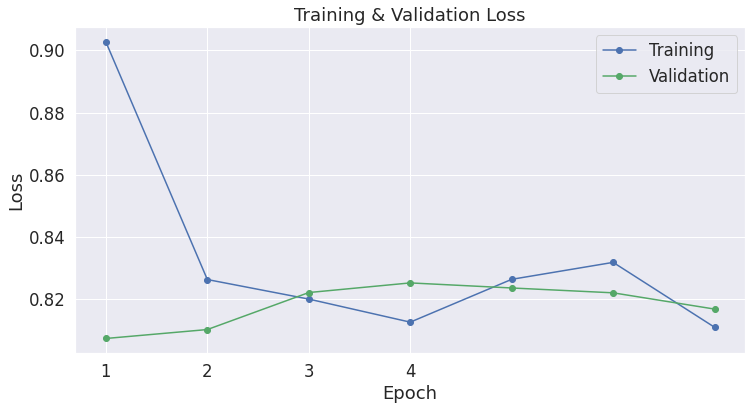

In [60]:
# CELL EXTRACTED FROM SAMPLE NOTEBOOK PROVIDED

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [61]:
# # CELL EXTRACTED FROM SAMPLE NOTEBOOK PROVIDED


# # Create sentence and label lists
# test_premise = test_df.sentence1.values
# test_hypothesis = test_df.sentence2.values
# test_labels = test_df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for i in tqdm(range(len(test_premise))):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = roberta_tok.encode_plus(
                        test_premise[i],                      # Sentence to encode.
                        test_hypothesis[i],
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        truncation=True,
                        padding = "max_length",
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  0%|          | 0/1205 [00:00<?, ?it/s]

In [62]:
# CELL EXTRACTED FROM SAMPLE NOTEBOOK PROVIDED

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in tqdm(prediction_dataloader):
  # Add batch to GPU
  batch = tuple(t.to("cuda:0") for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  pred_labels = np.argmax(logits, axis=1)
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.extend(pred_labels.tolist())
  true_labels.extend(label_ids.tolist())

print('DONE.')

Predicting labels for 1,205 test sentences...


  0%|          | 0/38 [00:00<?, ?it/s]

DONE.


In [63]:
# # CELL EXTRACTED FROM SAMPLE NOTEBOOK PROVIDED

# import os

# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = '/content/drive/MyDrive/NLP/modified_model/'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# roberta_tok.save_pretrained(output_dir)

# # Good practice: save your training arguments together with the trained model
# # torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [64]:
from sklearn.metrics import classification_report, confusion_matrix

result_report= classification_report(true_labels, predictions, digits=3, output_dict=True)
result_report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 249},
 '1': {'precision': 0.7427385892116183,
  'recall': 1.0,
  'f1-score': 0.8523809523809524,
  'support': 895},
 '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 61},
 'accuracy': 0.7427385892116183,
 'macro avg': {'precision': 0.2475795297372061,
  'recall': 0.3333333333333333,
  'f1-score': 0.2841269841269841,
  'support': 1205},
 'weighted avg': {'precision': 0.551660611904065,
  'recall': 0.7427385892116183,
  'f1-score': 0.6330962260422841,
  'support': 1205}}

In [65]:
confusion_matrix(true_labels, predictions)

array([[  0, 249,   0],
       [  0, 895,   0],
       [  0,  61,   0]])